In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

train_data = '/content/drive/My Drive/Datasheet/Image Classification/1-9 Classification/train.csv'
test_data  = '/content/drive/My Drive/Datasheet/Image Classification/1-9 Classification/test.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train = pd.read_csv(train_data)
test  = pd.read_csv(test_data)

In [3]:
train.info()
train.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [4]:
test.info()
test.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

In [5]:
print('Jumlah Missing Values :\n')
print(train.isnull().sum().sum())

Jumlah Missing Values :

0


In [6]:
print('Jumlah distribusi label pada data train :\n')
print(train['label'].value_counts())

Jumlah distribusi label pada data train :

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64


In [7]:
train['label'].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

In [8]:
print(train.shape)
print(test.shape)
print(train.columns[:10])
print(test.columns[:10])

(42000, 785)
(28000, 784)
Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8'],
      dtype='object')
Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9'],
      dtype='object')


In [9]:
X_train = train.drop('label', axis=1).to_numpy()
y_train = train['label'].to_numpy()
print(f'Shape train X: {X_train.shape}, y:{y_train.shape}')

Shape train X: (42000, 784), y:(42000,)


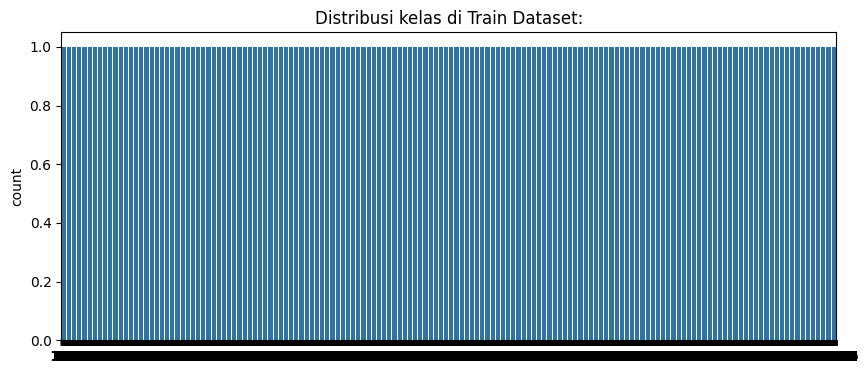

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.countplot(y_train)
plt.title('Distribusi kelas di Train Dataset:')
plt.show()

In [11]:
#Preprocessing
from tensorflow.keras.utils import to_categorical

X_test = test.to_numpy()
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
y_train = to_categorical(y_train, num_classes = 10)

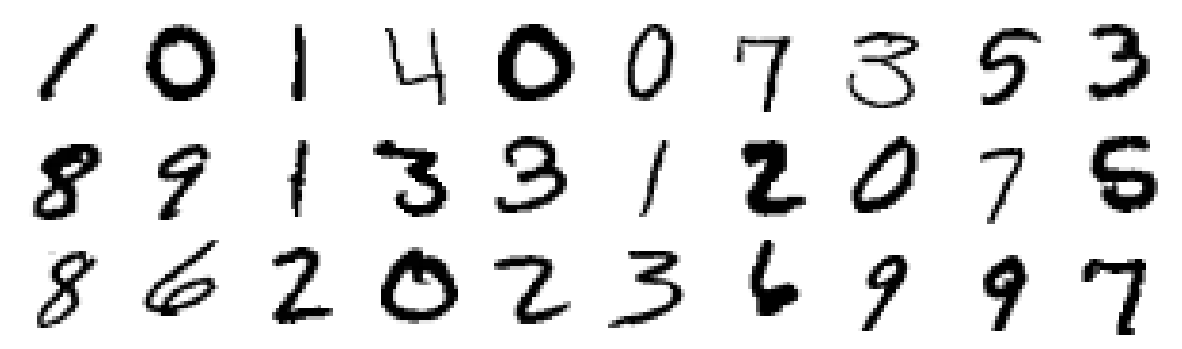

In [12]:
# Visualisasi beberapa contoh gambar
plt.figure(figsize=(15,4.5))
for i in range(30):
  plt.subplot(3, 10, i+1)
  plt.imshow(X_train[i].reshape((28,28)), cmap=plt.cm.binary)
  plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=-0.1)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

X_train_sp, X_val, y_train_sp, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)
print('Train:',X_train_sp.shape, y_train_sp.shape)
print('Val :',X_val.shape, y_val.shape)

Train: (37800, 28, 28, 1) (37800, 10)
Val : (4200, 28, 28, 1) (4200, 10)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.10,
        width_shift_range=0.1,
        height_shift_range=0.1)
datagen.fit(X_train_sp)

In [15]:
!pip install keras-tuner==1.4.6

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import keras_tuner as kt

# Build Model dengan Neural Architecture Search
def build_model_cnn (hp):
  model = models.Sequential()

  # Blok 1
  model.add(layers.Conv2D(
      filters=hp.Choice('block1_conv1_filters', [16,32,64]),   # Pencarian kombinasi filters menggunakan NAS
      kernel_size=hp.Choice('block1_conv1_kernel', [3,5]),         # Pencarian kombinasi kernel_size menggunakan NAS
      activation='relu',
      padding='same',
      input_shape=(28,28,1)
  ))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(
      filters=hp.Choice('block1_conv2_filters', [16,32,64]),
      kernel_size=hp.Choice('block2_conv2_kernel', [3,5]),
      activation='relu',
      padding='same'
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(hp.Choice('dropout1', [0.2,0.3])))

  # Blok 2
  model.add(layers.Conv2D(
      filters=hp.Choice('block2_conv1_filters', [32,64]),
      kernel_size=hp.Choice('block2_conv1_kernel', [3,5]),
      activation='relu',
      padding='same'
  ))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(
      filters=hp.Choice('block2_conv2_filters',[32,64]),
      kernel_size=hp.Choice('block2_conv2_kernel',[3,5]),
      activation='relu',
      padding='same'
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(hp.Choice('dropout2',[0.3,0.4])))

  # Blok 3
  model.add(layers.Conv2D(
      filters=hp.Choice('block3_conv1_filters', [64,128]),
      kernel_size=hp.Choice('block3_conv1_kernel', [3,5]),
      activation='relu',
      padding='same'
  ))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dropout(hp.Choice('dropout3',[0.3,0.5])))

  #Output
  model.add(layers.Dense(10, activation='softmax'))

  #Optimizier
  model.compile(
      optimizer=tf.keras.optimizers.Adam(
          hp.Choice('lr', [1e-3, 5e-4])
      ),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

tuner = kt.Hyperband(
    build_model_cnn,
    objective='val_accuracy',
    executions_per_trial=1,         # 1x training tiap kombinasi
    max_epochs=20,
    factor=3,
    directory='mnist_tuner',
    project_name='cnn_imageclassification',
    overwrite =True
)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
]

In [24]:
tuner.search(
    datagen.flow(X_train_sp, y_train_sp),
    validation_data=(X_val, y_val),
    epochs = 20, # Epochs per trial awal
    #batch_size=128,
    verbose=1,
    callbacks=callbacks
)

Exception ignored in: <function _xla_gc_callback at 0x7fdbb20768e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 120/1182 ━━━━━━━━━━━━━━━━━━━━ 4:21 247ms/step - accuracy: 0.3591 - loss: 2.1465

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Top 3 Model Terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=3)
best_models = tuner.get_best_models(num_models=3)
print("\n == Top 3 Model Terbaik ==")
for i, (hp,model) in enumerate(zip(best_hps, best_models), start=1):
  # Evaluasi model pada data test
  val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

  print(f'\nModel {i}:')
  print(f'Akurasi model terbaik pada data uji:{val_acc:.4f}')
  print(f'Loss model terbaik pada data uji:{val_loss:.4f}')
  print('Hyperparameters :')
  for param, value in hp.values.items():
    print(f'{param}:{value}')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



 == Top 3 Model Terbaik ==

Model 1:
Validation Accuracy: 0.9980
Hyperparameters :
conv_1_filters:32
conv_1_kernel:5
num_conv_layers:2
conv_2_filters:64
conv_2_kernel:5
conv_2_activation:relu
dense_units:64
dropout:0.2
learning_rate:0.001
tuner/epochs:20
tuner/initial_epoch:7
tuner/bracket:2
tuner/round:2
conv_3_filters:32
conv_3_kernel:3
conv_3_activation:relu
tuner/trial_id:0012

Model 2:
Validation Accuracy: 0.9982
Hyperparameters :
conv_1_filters:64
conv_1_kernel:5
num_conv_layers:2
conv_2_filters:64
conv_2_kernel:5
conv_2_activation:relu
dense_units:32
dropout:0.2
learning_rate:0.001
conv_3_filters:32
conv_3_kernel:3
conv_3_activation:elu
tuner/epochs:20
tuner/initial_epoch:7
tuner/bracket:2
tuner/round:2
tuner/trial_id:0014

Model 3:
Validation Accuracy: 0.9946
Hyperparameters :
conv_1_filters:64
conv_1_kernel:5
num_conv_layers:2
conv_2_filters:64
conv_2_kernel:5
conv_2_activation:relu
dense_units:32
dropout:0.2
learning_rate:0.001
conv_3_filters:32
conv_3_kernel:3
conv_3_activa

In [ ]:
best_models = tuner.get_best_models(num_models=1)[0]
best_models.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,322 (286.41 KB)

 Trainable params: 73,322 (286.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from google.colab import files
best_models.save('classification_image_CNN.h5')
files.download('classification_image_CNN.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>